# TPC2 -  Sistemas de Equações

<ul>
    <li>Não deve escrever o seu nome nem nenhum código identificador em nenhum sítio. </li>
    <li>Deve entregar ESTE Notebook de Jupyter.</li>
    <li>O trabalho é individual. Podem e devem haver discussões com colegas mas o resultado entregue é individual. </li>
    <li>Não deve acrescentar ou apagar nenhuma célula. </li>
    <li>Todas as explicações devem ser claras e concisas. </li>
    <li>É preferível fazer menos e fazer bem que muito e mal. </li>
    <li>O método @jit(nopython=True) do pacote numba pode diminuir o tempo de cálculo.</li>
    <li>A não verificação de alguma destas regras leva ao anulamento e exclusão da prova.</li>
</ul>


In [2]:
# Introduza o codigo geral aqui
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Sistema de massas livre
Considere um sistema de $N$ massas acopladas entre si e a duas paredes
fixas com $N+1$ molas:

\begin{equation}
m\frac{d^{2}X_{i}}{dt^{2}}=-k_{i}\left(X_{i}-X_{i-1}\right)+k_{i+1}\left(X_{i+1}-X_{i}\right)
\end{equation}
onde $X_{0}=0$ e $X_{N+1}=L$. Podemos usar como unidades de comprimento
a distância entre as paredes, a massa $m$ e como unidade de tempo
\begin{equation}
\tau=\sqrt{\frac{m}{\overline{k}}}
\end{equation}
onde $\overline{k}$ a constante média das molas.

1. Escreva uma rotina que resolva um sistema de equações usando uma eliminação
de Gauss com pivotagem parcial.

Escolhendo como unidade de comprimento o padrão de $L$ e a escala de comprimento $\tau$ obtemos as equações
\begin{align}
X_0 & = 0 \\
\frac{d^2 X_1}{dt^2} & = - (k_1 +k_2) X_1 + k_2 X_2 \\
\frac{d^2 X_n}{dt^2} & = k_n X_{n-1} - (k_n +k_{n+1} ) X_n + k_{n+1} X_{n+1} & 1 < n < N - 2 \\
\frac{d^2 X_{N-1}}{dt^2} & = k_{N-1} X_{N-2} - (k_{N-1} +k_{N}) X_{N-1} + k_N \\
X_N & = 1
\end{align}

Onde os valores $k_n$ foram divididos por $\overline{k}$.

In [3]:
# Introduza o codigo geral aqui
def solveGauss(AA, bb):
    M = len(bb)
    sol = 0 * bb
    enderecos = np.arange(M)
    A = np.zeros([M, M + 1])
    A[:,:M] = AA[:,:]
    A[:,M]  = bb[:]

    for p in range(M):
        indice = p + np.argmax( np.abs(A[enderecos[p:],p]))
        enderecos[p], enderecos[indice] = enderecos[indice], enderecos[p] 
        A[enderecos[p],p:] /= A[enderecos[p],p]
        
        for i in range(p + 1, M):
            A[enderecos[i], p:] += - A[enderecos[i],p] * A[enderecos[p],p:] 

    for p in range(M-1, -1, -1):
        sol[p] = (A[enderecos[p], -1] - A[enderecos[p], p + 1:-1]@sol[p+1:])/A[enderecos[p],p]
    return sol


2. Considerando massas iguais e molas iguais,

    (a) Em que condições o sistema está em equilíbrio? Resolva o correspondente sistema de equações e obtenha as posições de equilíbrio ($X_{i}^{eq}$).

As condições de equlíbrio são obtidas igualando as derivadas a zero. 

\begin{align}
- (k_1 +k_2) X_1 + k_2 X_2 & = 0\\
k_n X_{n-1} - (k_n +k_{n+1} ) X_n + k_{n+1} X_{n+1} &=0  & 1 < n < N - 2 \\
k_{N-1} X_{N-2} - (k_{N-1} +k_{N}) X_{N-1} &= - k_N \\
\end{align}

Ou seja podemos escrever como $A_{ij} X_j = b_i$ (usando a convenção de índices repetidos) sendo $A$ uma matriz tridiagonal  de dimensão $N-1$

\begin{equation}
\left(\begin{array}{cccccccc}
-\left(k_{1}+k_{2}\right) & k_{2} & 0 & 0 & \cdots & 0 & 0 & 0\\
k_{2} & -\left(k_{2}+k_{3}\right) & k_{3} & 0 & \cdots & 0 & 0 & 0\\
0 & k_{3} & -\left(k_{3}+k_{4}\right) & k_{4} & \cdots & 0 & 0 & 0\\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots\\
0 & 0 & 0 & 0 & \cdots & -\left(k_{N-3}+k_{N-2}\right) & k_{N-2} & 0\\
0 & 0 & 0 & 0 & \cdots & k_{N-2} & -\left(k_{N-2}+k_{N-1}\right) & k_{N-1}\\
0 & 0 & 0 & 0 & \cdots & 0 & k_{N-1} & -\left(k_{N-1}+k_{N}\right)
\end{array}\right)
\end{equation}

O vector $b_i$ será dado por
$$
\begin{equation}
\left(\begin{array}{c}
0\\
0\\
\vdots\\
0\\
-k_{N}
\end{array}\right)
\end{equation}
$$

In [4]:
def build_matrix(k):
    M = len(k)
    A = np.zeros([M-1, M - 1])
    ind = np.arange(M)
    A[ind[:-1], ind[:-1] ] = -(k[:-1] + k[1:])  
    A[ind[:-2], ind[:-2] + 1] = k[1:-1]
    A[ind[:-2]+1,ind[:-2]] = k[1:-1]
    return A

(b) Verifique que no equilíbrio as distâncias entre massas são sempre iguais e iguais a $1/(N+1)$.

Gerando um vector de com dez molas (nove massas) iguais podemos construir a Matriz de dimensão nove. Como dividimos a distância de um por dez molas, o espaçamento é de 0.1 na nossa escolha de unidades adimensionais. 

In [5]:
NMassas = 9
k = np.ones(NMassas + 1,dtype=float)
A = build_matrix(k)
b = np.zeros(NMassas)
b[-1] = -k[-1]
X = np.concatenate( (np.array([0]), solveGauss(A,b), np.array([1]))) # Vector completo de coordenadas X
print("As posições das extremidades das molas são:")
X

As posições das extremidades das molas são:


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

3. Gere aleatoriamente valores de $k_{i}$ usando uma distribuição gaussiana
de largura $\sigma=0.1$ e valor médio $\mu=1$. Faça um histograma
das diferenças entre as posições de equilíbrio de massas consecutivas
para um sistema com $N=2^{10}$.

Podemos usar o gerador de números pseudoaleatórios com distribuião gaussiana do numpy (numpy.random.normal) para gerar a matriz.Para cada configuração de molas geramos a distribuição de equílibrio e calculamos as diferenças. Repetimos este processo várias vezes para aumentar a amostra estatística.   

Para construir e representar o histograma usamos o função hist do matplotlib. 

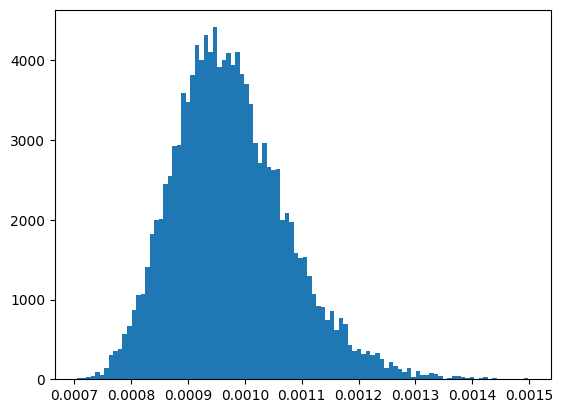

In [6]:
NMassas = 2**10 
DX = np.array([])
for i in range(10):
    k = np.random.normal(1,0.1,size=(NMassas + 1))
    A = build_matrix(k)
    b = np.zeros(NMassas)
    b[-1] = -k[-1]
    X = np.concatenate( (np.array([0]), solveGauss(A,b), np.array([1]))) # Vector completo de coordenadas X
    dx = X[1:] - X[:-1]
    DX = np.concatenate((DX,dx))
z1, z2 , z3 = plt.hist(DX,bins=100,density=True)

4. Fazendo a mudança de variável, $x_{i}=X_{i}-X_{i}^{eq}$ podemos transformar
o sistema de equações diferenciais em,
\begin{equation}
\frac{d^{2}x_{i}}{dt^{2}}=A_{ij}x_{j}\qquad\text{com }1\le i\le N
\end{equation}
onde é usada a convenção de índices repetidos e a matriz $A$ é simétrica
e tridiagonal.

(a) Note que sabendo os valores próprios do sistema de $A$, $\lambda_{\beta}$, e os respectivos vectores próprios $v_{i}^{\beta}$ (devidamente normalizados $\sum_{i}v_{i}^{\beta}v_{i}^{\alpha}=\delta_{\alpha\beta}$), podemos construir um novo conjunto de variáveis,\begin{equation}f_{\beta}=U_{\beta i}^{T}x_{i} \end{equation} onde $U$ é uma matriz ortogonal com os vectores próprios, $v_{i}^{\beta},$em cada coluna e $U^{T}$ é a sua transposta ($U_{j\alpha}U_{\alpha i}=\delta_{ji}$).
Note-se ainda, que 
\begin{equation}
\sum_{i,j}U_{\beta i}^{T}A_{ij}U_{j\alpha}=D_{\alpha\beta}
\end{equation}
onde $D$ é a matriz diagonal com os valores, $D_{\alpha\alpha}=\lambda_{\alpha}$.
Fazendo a mudança de coordenadas associada a esta transformação ortogonal,
obtemos o seguinte sistema equivalente
\begin{align*}
\frac{d^{2}f_{\beta}}{dt^{2}} & =D_{\beta\alpha}f_{\alpha}.
\end{align*}
Como $D$ é diagonal as equações desacoplam, i.e.
\begin{equation}
\frac{d^{2}f_{\beta}}{dt^{2}}=\lambda_{\beta}f_{\beta},
\end{equation}
que admitem soluções da forma
\begin{equation}
f_{\beta}=A_{\beta}e^{t\sqrt{\lambda_{\beta}}}+B_{\beta}e^{-t\sqrt{\lambda_{\beta}}}
\end{equation}
Logo a diagonalização da matriz $A$ permite a solução do sistema
de equações no tempo. Utilize a decomposição $QR$ para obter, quer
os valores próprios, quer os vectores próprios de uma matriz com $k_{i}$
aleatórios como descrito anteriormente ( $N=10$).

Como a matriz é simétrica pode ser diagonalizada com a decomposição QR. Para fazer esta decomposição usamos o processo de Gram-Schmidt. Juntamos um teste para verificar que a diagonalização está a funcionar.

In [8]:
def QRGramSchmidt(A):
    M = len(A)
    Q = np.zeros([M,M])
    R = np.zeros([M,M])
    
    for i in range(M):
        v = A[:,i] - np.dot(Q[:,:i] , np.dot(A[:,i], Q[:,:i]) )
        vv = np.linalg.norm(v) 
        Q[:,i] = v/vv
        R[i, i:] = np.dot(Q[:,i],A[:,i:])
    return Q, R

def EigenSystem(AA, tol):
    erro = 1
    M = len(AA)
    A = AA.copy()
    U = np.identity(M)
    while(erro > tol ):
        Q, R = QRGramSchmidt(A)
        A = R @ Q
        U = U @ Q
        erro = np.linalg.norm(A - np.diag(np.diag(A)))/np.linalg.norm(A)
    return np.diag(A), U

NMassas = 10
k = np.random.normal(1,0.1,size=(NMassas + 1))
M = build_matrix(k)
b = np.zeros(NMassas)
b[-1] = -k[-1]
Xeq = solveGauss(M,b)
val, v = EigenSystem(M, 1E-12)  
print( "Verificar que os valores próprios e vectores proprios estão bem calculados:\n", np.linalg.norm(M @ v -  v @ np.diag(val) ) )

Verificar que os valores próprios e vectores proprios estão bem calculados:
 6.882480926641737e-12


(b) Sabendo a forma das equações próprias do sistema, a evolução temporal
nas coordenadas $x_{i}(t)$ é dada por 
\begin{equation}
x_{i}=U_{i\beta}A_{\beta}e^{t\sqrt{\lambda_{\beta}}}+U_{i\beta}B_{\beta}e^{-t\sqrt{\lambda_{\beta}}}
\end{equation}
Logo para determinar a evolução temporal, apenas falta definir as
contantes $A_{\beta}$ e $B_{\beta}$ a partir das condições iniciais.
Tome como condição inicial as velocidades nulas e as posições aleatórias
com $x\in]-1/(N+1),1/(N+1)[$. Obtenha as constantes $A_{\beta}$
e $B_{\beta}$.

As constantes $A_\beta$ e $B_\beta$ podem ser obtidas a partir das condições iniciais. 
\begin{align}
x_i(0)  & = x_i   = U_{i\beta} (A_\beta + B_\beta) \\
\frac{dx_i(t)}{dt} & = 0   = U_{i\beta} \sqrt{\lambda_\beta} (A_\beta - B_\beta) \\
\end{align}
Onde usamos a convenção de índices repetidos. Como $U$ é uma matriz ortogonal a sua é dada pela sua transposta. Logo, 
\begin{align}
A_\beta + B_\beta = [U^T]_{\beta i} x_i \\
A_\beta =  B_\beta \\
\end{align}

\begin{align}
A_\beta  = \frac{[U^T]_{\beta i} x_i}{2} \\
A_\beta =  B_\beta \\
\end{align}


In [9]:
tempos = np.linspace(0,100, 1000)
x = (2*np.random.random_sample(NMassas) - 1)/(NMassas + 2) 
A = (v.T @ x)/2
print(A)

[-0.01790369  0.00193015 -0.00410065 -0.00478588  0.0174461  -0.00691736
 -0.05160959 -0.02161849 -0.02867304 -0.02240709]


(c) Represente no tempo a posição de cada uma das massas a partir das condições iniciais da alínea anterior.

A evolução temporal pode ser contruída a partir destas condições iniciais como,
\begin{equation}
x_{i}=U_{i\beta}A_{\beta}\left( e^{t\sqrt{\lambda_{\beta}}}+e^{-t\sqrt{\lambda_{\beta}}}\right)
\end{equation}
Uma vez que todos os valores próprios são negativos,
\begin{equation}
x_{i}=2 U_{i\beta}A_{\beta} \cos( t\sqrt{| \lambda_{\beta}|} )
\end{equation}

Para cada tempo podemos estruturar este calculo como uma multiplicação de uma matriz $U_{i \beta}$  por um vector coluna $A_{\beta} \cos( t\sqrt{| \lambda_{\beta}|} )$. Para o fazer para uma lista de tempo, podemos promover este último objecto a uma matriz em que cada coluno é um valor de $t$.

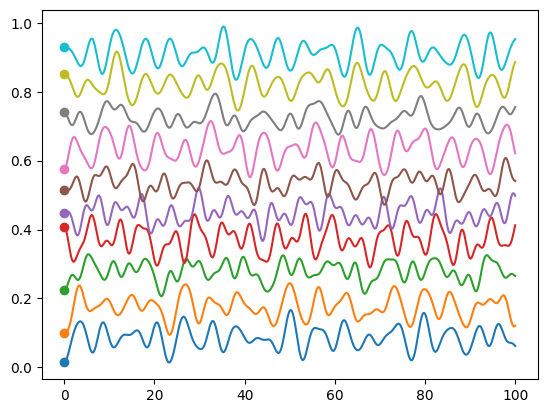

In [10]:
sol = np.array([Xeq]).T + v @ (np.array([2 * A]).T * np.cos(np.outer(np.sqrt(np.abs(val)), tempos)))
for i in range(NMassas):
    plt.plot(tempos, sol[i,:])
    plt.scatter(0, Xeq[i] + x[i])

# Sistema de massas forçado
Considere o sistema de massas discutido na pergunta anterior e aplique
uma força na massa $l$ dada por, 
\begin{align*}
F_{l} & =Fe^{i\Omega t}\\
m\frac{d^{2}x_{i}}{dt^{2}} & =-k_{i}\left(x_{i}-x_{i-1}\right)+k_{i+1}\left(x_{i+1}-x_{i}\right)+\delta_{il}Fe^{i\Omega t-\gamma|t|}
\end{align*}

Fazendo a transformada de Fourier, desta equação obtemos 
\begin{equation}
-m\omega^{2}x_{i}(\omega)=-k_{i}\left(x_{i}(\omega)-x_{i-1}(\omega)\right)+k_{i+1}\left(x_{i+1}(\omega)-x_{i}(\omega)\right)+\frac{2\gamma F}{\gamma^{2}+(\omega-\Omega)^{2}}\delta_{il}
\end{equation}
onde para cada $\Omega$ obtemos uma solução $x_{i}(\omega)$. Analisando,
apenas para $\omega=\Omega$ e considerando $\tilde{F}=2F/\gamma$

1. Considerando o sistema aleatório com $N=10$ e $\tilde{F}=1$ e $l=1$, represente num gráfico com as ordenadas em escala logarítmica as soluções $|x_{i}(\Omega)|$ como função de $\Omega$. Todas as curvas têm os mesmos máximos?

Na representação de $x_i(\Omega)$ para diferentes frequências  podemos observar picos pronunciados em frequências específicas. Estes picos são visíveis em todas as massas. 

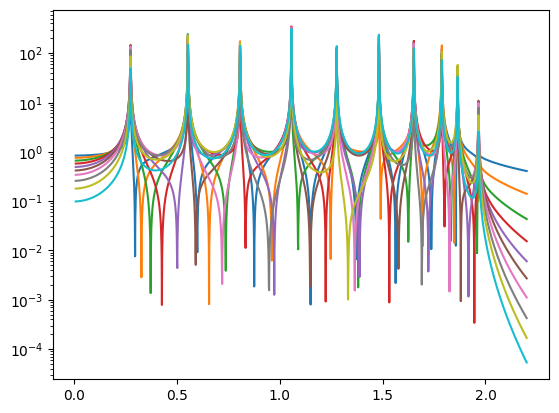

In [96]:
b = np.zeros(NMassas)
b[0] = -1
NOmegas = 2000
Omegas = np.linspace(0.01,2.2,NOmegas)
xOmega = np.zeros([NMassas, NOmegas],dtype=float)

for i, Omega in enumerate(Omegas):
    Al = M + np.identity(NMassas) * Omega**2
    xOmega[:,i] = solveGauss(Al,b)
    
for i in range(NMassas):
    plt.plot(Omegas, np.abs(xOmega[i,:]) )
plt.yscale('log')

2. Identifique na alínea anterior a posição dos valores próprios do sistema.

O módulo dos valores próprios estão associados ao quadrado de uma frequência. Representando com linhas verticais a tracejado as frequências próprios do sistema podemos observar que as ressonâncias são precisamente nesses valores. 
Nestas frequências, uma excitação por pequena que seja dá origem a uma resposta aumentada que apenas não diverge devido à existência de ao termo de convergência associado a $\gamma$.

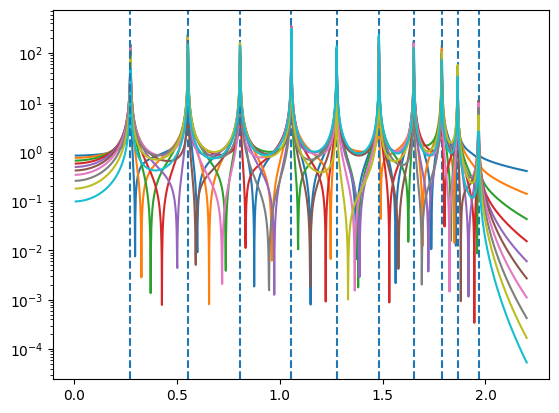

In [97]:
for i in range(NMassas):
    plt.plot(Omegas, np.abs(xOmega[i,:]) )
    plt.axvline(np.sqrt(np.abs(val[i])) ,ls='--')

plt.yscale('log')

3.  Escolha algumas das frequências onde existem os picos e as respectivas soluções $x_{i}$. Para cada uma das soluções escolhidas, normalize-a e transforme as suas coordenadas calculando,
\begin{equation}
f_{\beta}=U_{\beta i}^{T}x_{i}.
\end{equation}
Represente cada um dos $\left|f_{\beta}\right|$ que obteve. Que conclusões pode tirar?

Escolhendo exactamente as frequências associadas aos modos próprios do sistema livre, podemos verificar que quando transformamos coordenadas de $x_i$ para $f_\beta$ cada curva apenas é ressonante numa das coordenadas de $f$. Isso deve-se precisamente ao facto que cada frequência excita apenas um dos modos próprios. 


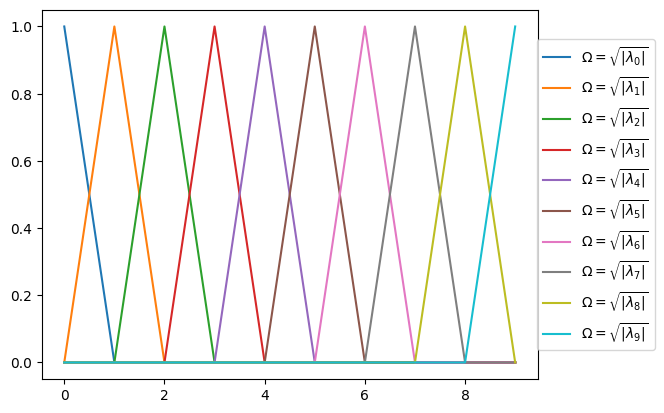

In [37]:
xxOmega=np.zeros(NMassas)
b = np.zeros(NMassas)
b[0] = -1
for i,Omega in enumerate(np.sqrt(np.abs(val)) ):
    Al = M + np.identity(NMassas) * Omega**2
    xxOmega = solveGauss(Al,b)
    xxOmega /= np.linalg.norm(xxOmega)
    fOmega = v.T @ xxOmega
    plt.plot(np.arange(NMassas), np.abs(fOmega),label=r"$\Omega = \sqrt{|\lambda_" + str(i)+"|}$" )    
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))


4. Repita o procedimento anterior adicionando uma outra força para $i=10$ mas com amplitude $\tilde{F}=-1$ na equação da transformada de Fourier (mantemos a força em $l=1$). O que observa? 

A introdução de uma segunda força noutra massa não altera os resultados anteriores. Mesmo sendo uma força exactamente oposta. 

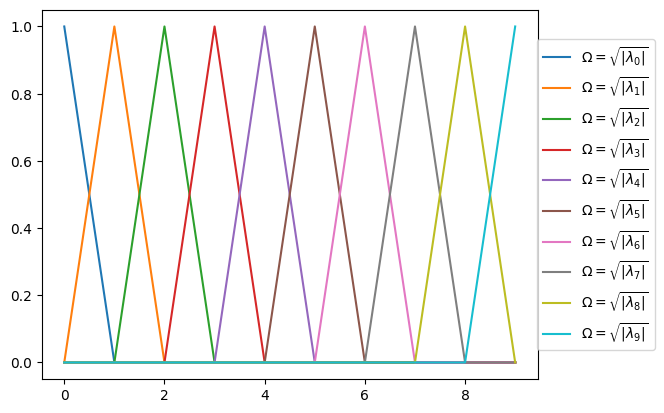

In [38]:
b = np.zeros(NMassas)
b[0] = -1
b[9] = 1
for i,Omega in enumerate(np.sqrt(np.abs(val)) ):
    Al = M + np.identity(NMassas) * Omega**2
    xxOmega = solveGauss(Al,b)
    xxOmega /= np.linalg.norm(xxOmega)
    fOmega = v.T @ xxOmega
    plt.plot(np.arange(NMassas), np.abs(fOmega),label=r"$\Omega = \sqrt{|\lambda_" + str(i)+"|}$" )    
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))


Bom Trabalho